# Load Data

In [754]:
# About Dataset:
# Data ranges from January 2nd, 2020 to February 2nd, 2024
# Contains two columns for each asset, the daily price and the volume

# Commodities: Prices and trading volumes for natural gas, crude oil, copper, platinum, silver, and gold.
# Cryptocurrencies: Prices and volumes for Bitcoin and Ethereum, including detailed 5-minute interval data for Bitcoin.
# Stock Market Indices: Data for major indices such as the S&P 500 and Nasdaq 100.
# Individual Stocks: Prices and volumes for major companies including Apple, Tesla, Microsoft, Google, Nvidia, Berkshire Hathaway, Netflix, Amazon, and Meta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

assets = pd.read_csv('data/US_Stock_Data.csv')

print(assets.head())

   Unnamed: 0        Date  Natural_Gas_Price  Natural_Gas_Vol.  \
0           0    2/2/2024              2.079               NaN   
1           1    1/2/2024              2.050          161340.0   
2           2  31-01-2024              2.100          142860.0   
3           3  30-01-2024              2.077          139750.0   
4           4  29-01-2024              2.490            3590.0   

   Crude_oil_Price  Crude_oil_Vol.  Copper_Price  Copper_Vol. Bitcoin_Price  \
0            72.28             NaN        3.8215          NaN     43,194.70   
1            73.82        577940.0        3.8535          NaN     43,081.40   
2            75.85        344490.0        3.9060          NaN     42,580.50   
3            77.82        347240.0        3.9110          NaN     42,946.20   
4            76.78        331930.0        3.8790          NaN     43,299.80   

   Bitcoin_Vol.  ... Berkshire_Price  Berkshire_Vol. Netflix_Price  \
0         42650  ...        5,89,498           10580      

# DATA WRANGLING

In [755]:
# Date column has dates with - and / seperators, want just one
assets['Date'] = assets['Date'].str.replace('/', '-')


In [756]:
# can also see some months have a 0 before and some do not
# going to add leading zero to single digit month

# Now that we have dashes can use a regex to repalce a single month (-6-) with a leading 0 (-06-) for consistent date formatting
assets['Date'] = assets['Date'].str.replace(r'-(\d)-', r'-0\1-', regex=True)

In [757]:
# we know that linear regression requires two numeric values, so must convert Date to the correct type
print(assets['Date'].dtype)

object


In [758]:
# converting Date from object to datetime
assets['Date'] = pd.to_datetime(assets['Date'], dayfirst = True, errors = 'coerce')

In [759]:
# column is now a datetime 
print(assets['Date'].dtype)

datetime64[ns]


In [760]:
# since it is converted to datetime we can create a oridnal date column starting at 0 and spanning the length of days within the dataset
assets.loc[:, 'Date_Ordinal'] = assets['Date'].apply(lambda x: x.toordinal() - assets['Date'].min().toordinal()) # Converts each date to ordinal format, a continuous integer representing days, then normalizes so the column starts from 0.

# Referenced: https://www.geeksforgeeks.org/python-datetime-toordinal-method-with-example/

In [761]:
# need to remove the rows representing the first two day of Feb 2024 from assets, so data strictly goes from January 2020 through January 2024
assets = assets[~assets['Date'].isin(['2024-02-01', '2024-02-02'])]

# Referenced: https://sqlpey.com/python/top-12-methods-to-remove-rows-from-a-pandas-dataframe/

# EDA

- **Exploratory Data Analysis (EDA)**:  

  - For summary statistics, we will calculate measurements of central tendency (mean) and measures of dispersion (min, max). Calculating these statistics will help us understand how our data may behave in the future in our models. We will also look into monthly percent changes to see if any months yield higher returns.

  
- **Planned Visualizations**:
  - Line plots of stock prices over time  
  - Histograms for stock price distributions

  In the Microsoft EDA section, functions will be created in order to replicate analysis for other assets.

### Microsoft (MSFT) EDA

In [762]:
def asset_summary_stats(stock):

    '''
    This function takes a stock and displays its highest, lowest and average value from the dataset, which ranges from January 2, 2020 to January 31, 2024.
    It also displays the dates where the highest and lowest prices occurred.

    Parameters:
    stock: the name of the stock being analyzed
    '''
    assets[stock] = assets[stock].astype(float) # convert to float for summary stats

    stock_name = stock.replace('_Price', '') # remove _price for display

    summary_data = {
        "Statistic": ["Highest Price", "Lowest Price", "Average Price"],
        f"{stock_name} Price ($)": [
            round(assets[stock].max(), 2),
            round(assets[stock].min(), 2),
            round(assets[stock].mean(), 2),
        ], 
        "Date": [
        assets.loc[assets[stock].idxmax(), 'Date'],
        assets.loc[assets[stock].idxmin(), 'Date'],
        None
        ]
    }

    summary_table = pd.DataFrame(summary_data) # convert dict to df

    print(f"Summary of {stock_name} Prices\nJanuary 2, 2020 - January 31, 2024\n")
    print(summary_table.to_string(index = False))

asset_summary_stats('Microsoft_Price')

Summary of Microsoft Prices
January 2, 2020 - January 31, 2024

    Statistic  Microsoft Price ($)       Date
Highest Price               409.72 2024-01-29
 Lowest Price               135.42 2020-03-16
Average Price               265.56        NaT


Microsoft's lowest stock price ocurred 10 weeks into the start of the data collection (March 16, 2020). The highest price occured on the last day the data was collected (January 29, 2024). Over the duration of the 212 weeks the data was collected the stocks value ranged $275.80, showing the stock price has greatly increased since its low points in 2020. The currently value of the MSFT stock as of December 4, 2024 is $437.42, showing a 6.8% increase since January 2024. Based on minimal analysis we could suspect that time and the price of MSFT are slightly positively correlated and have a somewhat positive linear relationship.

In [764]:
def avg_price_per_month(stock):
    '''
    This function takes an asset as an input and finds the average price of that asset for each month in the dataset.
    A column percent_change calculates the price the stock has changed since the previous month.
    The Positive_Month column indicates if a stock has increased since the previous month with a 1, and 0 if it has decreased. 

    Parameters:
    stock: the name of the stock being analyzed

    Returns:
    monthly_avg for use in visualizations
    '''

    # create df with just date and stock price
    data = assets[['Date', stock]].copy()

    # get year and month from date column
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    # group by year and month, and calc the avg price for each month
    monthly_avg = data.groupby(['Year', 'Month'], as_index=False).agg({stock: 'mean'})

    # rename column to relfect new meaning
    monthly_avg.rename(columns={stock: 'Avg_Price'}, inplace=True)

    # calc percent change from the previous month
    monthly_avg['Percent_Change'] = monthly_avg['Avg_Price'].pct_change() * 100

    # round both new aggregated columns
    monthly_avg[['Avg_Price', 'Percent_Change']] = monthly_avg[['Avg_Price', 'Percent_Change']].round(2)

    # combine columns for graphing
    monthly_avg['Year_Month'] = pd.to_datetime(
        monthly_avg['Month'].astype(str) + '-' + monthly_avg['Year'].astype(str)
    )

    # create boolean column showing if the stock price went up that month
    monthly_avg['Positive_Month'] = (monthly_avg['Percent_Change'] > 0).astype(int)

    # REMEMBER: first month value in positive_month column is 0, so need to exclude this value when counting total positive and negative months

    positive_count = monthly_avg['Positive_Month'].value_counts().get(1, 0)  # count of months with increase in avg price
    negative_count = monthly_avg['Positive_Month'].value_counts().get(0, 0) - 1 # subtract 1 because the first month should not be included

    print(monthly_avg.head())

    print(f"\nNumber of months where {stock} increased: {positive_count}")
    print(f"\nNumber of months where {stock} decreased: {negative_count}")
    print(f"\nThe average monthly percent return of the {stock} between January 2020 and January 2024' is", str(round(monthly_avg['Percent_Change'].mean(), 2)) + "%")

    return monthly_avg

avg_price_per_month('Microsoft_Price')

# Referenced: 
# https://www.statology.org/pandas-percent-change/ (pct_change)
# https://www.geeksforgeeks.org/how-to-count-occurrences-of-specific-value-in-pandas-column/


   Year  Month  Avg_Price  Percent_Change Year_Month  Positive_Month
0  2020      1     164.00             NaN 2020-01-01               0
1  2020      2     178.72            8.98 2020-02-01               1
2  2020      3     152.55          -14.64 2020-03-01               0
3  2020      4     169.04           10.81 2020-04-01               1
4  2020      5     182.38            7.89 2020-05-01               1

Number of months where Microsoft_Price increased: 33

Number of months where Microsoft_Price decreased: 15

The average monthly percent return of the Microsoft_Price between January 2020 and January 2024' is 1.99%


/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/1740799383.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['Year_Month'] = pd.to_datetime(


,Year,Month,Avg_Price,Percent_Change,Year_Month,Positive_Month
0,2020,1,164.00,NaN,2020-01-01,0
1,2020,2,178.72,8.98,2020-02-01,1
2,2020,3,152.55,-14.64,2020-03-01,0
3,2020,4,169.04,10.81,2020-04-01,1
4,2020,5,182.38,7.89,2020-05-01,1
5,2020,6,192.70,5.66,2020-06-01,1
6,2020,7,206.91,7.37,2020-07-01,1
7,2020,8,214.35,3.60,2020-08-01,1
8,2020,9,209.11,-2.44,2020-09-01,0
9,2020,10,212.89,1.81,2020-10-01,1


/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/3603179910.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['Month_Year'] = pd.to_datetime(


   Year  Month  Avg_Price  Percent_Change Month_Year  Positive_Month
0  2020      1     164.00             NaN 2020-01-01               0
1  2020      2     178.72            8.98 2020-02-01               1
2  2020      3     152.55          -14.64 2020-03-01               0
3  2020      4     169.04           10.81 2020-04-01               1
4  2020      5     182.38            7.89 2020-05-01               1

Number of months where Microsoft_Price increased: 33

Number of months where Microsoft_Price decreased: 15

The average monthly percent return of the Microsoft_Price between January 2020 and January 2024' is 1.99%


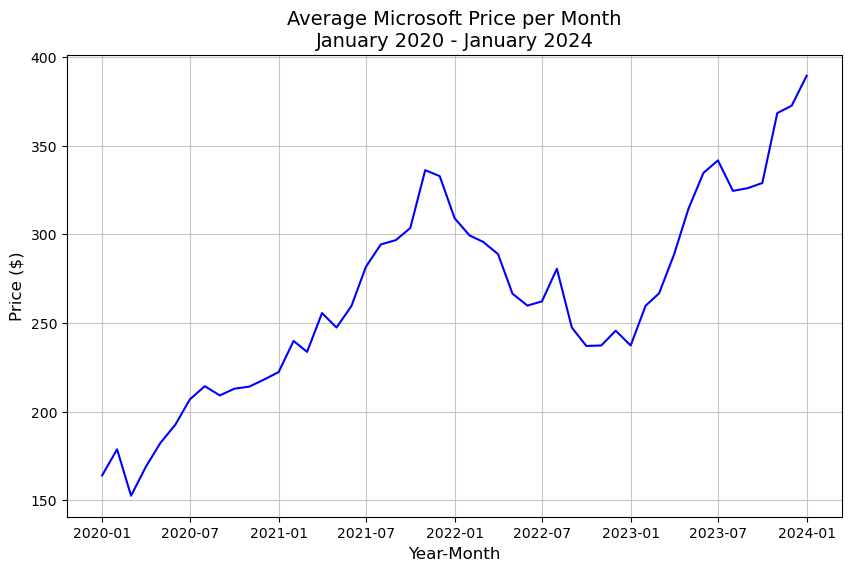

In [724]:
def avg_price_per_month_viz(df, stock):
    '''
    This function takes a data frame containing asset prices and an asset name and creates a line plot displaying the monthly average prices for that asset.
    
    Parameters:
    df: the dateframe containing the monthly average prices
    stock: the name of the stock being analyzed
    '''
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['Month_Year'], df['Avg_Price'], color='blue')
    plt.xlabel('Year-Month', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title(f'Average {stock} Price per Month\nJanuary 2020 - January 2024', fontsize=14)
    plt.grid(alpha=0.7)
    plt.show()

msft_monthly_avg = avg_price_per_month('Microsoft_Price')

avg_price_per_month_viz(msft_monthly_avg, 'Microsoft')


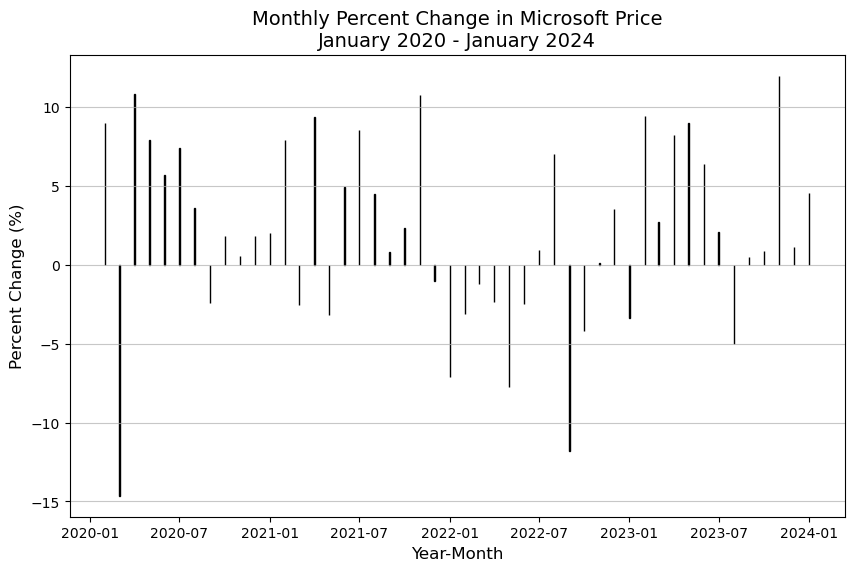

In [ ]:
def monthly_percent_change_viz(df, stock):
    '''
    This function takes a data frame containing assets and an asset name as an input and creates a bar plot displaying the monthly percent changes for that asset.
    
    Parameters:
    df: the dateframe containing the percent changes
    stock: the name of the stock being analyzed, used to insert name of stock into title
    '''
    
    plt.figure(figsize=(10, 6))
    plt.bar(df['Month_Year'], df['Percent_Change'], edgecolor='black')
    plt.xlabel('Year-Month', fontsize=12)
    plt.ylabel('Percent Change (%)', fontsize=12)
    plt.title(f'Monthly Percent Change in {stock} Price\nJanuary 2020 - January 2024', fontsize=14)
    plt.grid(axis='y', alpha=0.7)
    plt.show()

monthly_percent_change_viz(msft_monthly_avg, 'Microsoft')


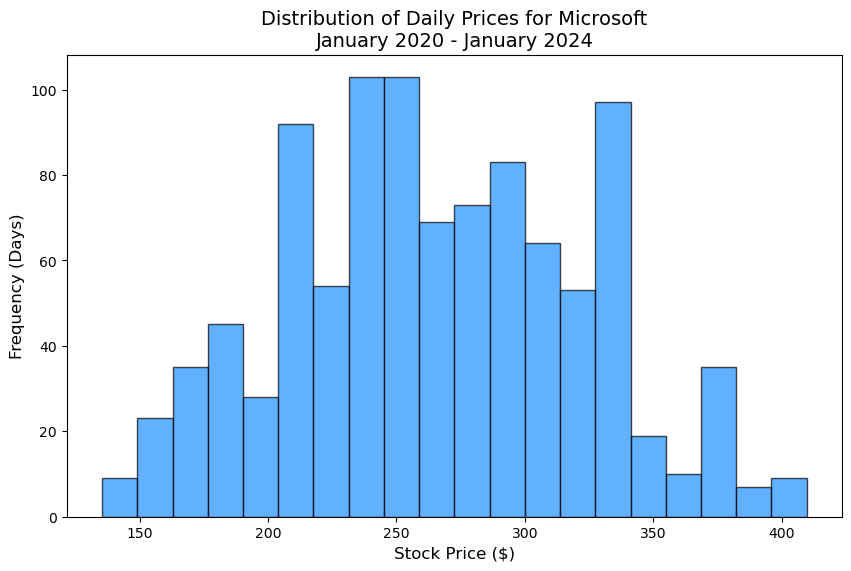

In [ ]:
def price_distribution_viz(df, stock):
    '''
    This function takes a data frame containing assets and an asset as an input and creates a histogram displaying the frequency of monthly average prices for that asset.
    
    Parameters:
    df: the dateframe containing the monthly average prices
    stock: the name of the stock being analyzed
    '''

    stock_name = stock.replace('_Price', '') # remove _price for ploltting the title

    plt.figure(figsize=(10, 6))
    plt.hist(df[stock], bins=20, color='dodgerblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Stock Price ($)', fontsize=12)
    plt.ylabel('Frequency (Days)', fontsize=12)
    plt.title(f'Distribution of Daily Prices for {stock_name}\nJanuary 2020 - January 2024', fontsize=14)
    plt.show()

price_distribution_viz(assets, 'Microsoft_Price')


Based on this histogram we can see that the price of the Micorosoft stock between Jan. 2020 and Jan 2024. most frequently hovered around $230 and $260.

### Apple (AAPL) EDA

In [620]:
asset_summary_stats('Apple_Price')

Summary of Apple Prices
January 2, 2020 - January 31, 2024

    Statistic  Apple Price ($)       Date
Highest Price           198.11 2023-12-14
 Lowest Price            56.09 2020-03-23
Average Price           141.88        NaT


Apples's lowest stock price ocurred on March 23,2020. The highest price occured on the December 14, 2023, about 6 weeks before the data collection period ended. Over the duration of the 212 weeks the data was collected the stocks value ranged $142.02, showing the stock price has greatly increased since its low points in March of 2020. The currently value of the AAPL stock as of December 6, 2024 is $242.84, showing a 22.6% increase since the datasets highest apple stock price, $198.11 on December 14, 2023. Based on minimal analysis we could suspect that as time goes on the price of Apple's stock will rise.

In [765]:
avg_price_per_month('Apple_Price')

   Year  Month  Avg_Price  Percent_Change Year_Month  Positive_Month
0  2020      1      77.98             NaN 2020-01-01               0
1  2020      2      77.82           -0.21 2020-02-01               0
2  2020      3      65.61          -15.69 2020-03-01               0
3  2020      4      68.10            3.79 2020-04-01               1
4  2020      5      77.41           13.67 2020-05-01               1

Number of months where Apple_Price increased: 28

Number of months where Apple_Price decreased: 20

The average monthly percent return of the Apple_Price between January 2020 and January 2024' is 2.09%


/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/1740799383.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['Year_Month'] = pd.to_datetime(


,Year,Month,Avg_Price,Percent_Change,Year_Month,Positive_Month
0,2020,1,77.98,NaN,2020-01-01,0
1,2020,2,77.82,-0.21,2020-02-01,0
2,2020,3,65.61,-15.69,2020-03-01,0
3,2020,4,68.10,3.79,2020-04-01,1
4,2020,5,77.41,13.67,2020-05-01,1
5,2020,6,86.45,11.68,2020-06-01,1
6,2020,7,95.66,10.65,2020-07-01,1
7,2020,8,117.30,22.62,2020-08-01,1
8,2020,9,115.24,-1.76,2020-09-01,0
9,2020,10,116.41,1.02,2020-10-01,1


/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/3603179910.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['Month_Year'] = pd.to_datetime(


   Year  Month  Avg_Price  Percent_Change Month_Year  Positive_Month
0  2020      1      77.98             NaN 2020-01-01               0
1  2020      2      77.82           -0.21 2020-02-01               0
2  2020      3      65.61          -15.69 2020-03-01               0
3  2020      4      68.10            3.79 2020-04-01               1
4  2020      5      77.41           13.67 2020-05-01               1

Number of months where Apple_Price increased: 28

Number of months where Apple_Price decreased: 20

The average monthly percent return of the Apple_Price between January 2020 and January 2024' is 2.09%


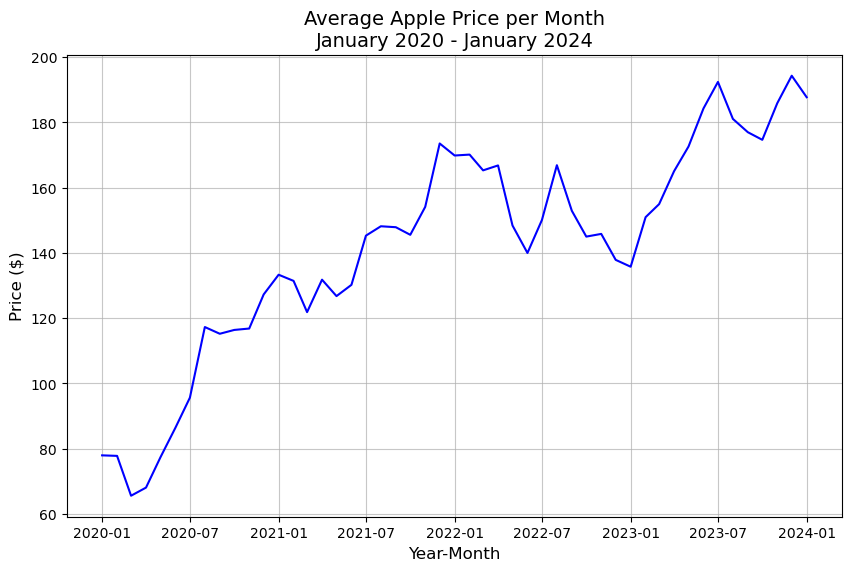

In [726]:
apple_monthly_avg = avg_price_per_month('Apple_Price')

avg_price_per_month_viz(apple_monthly_avg, 'Apple')


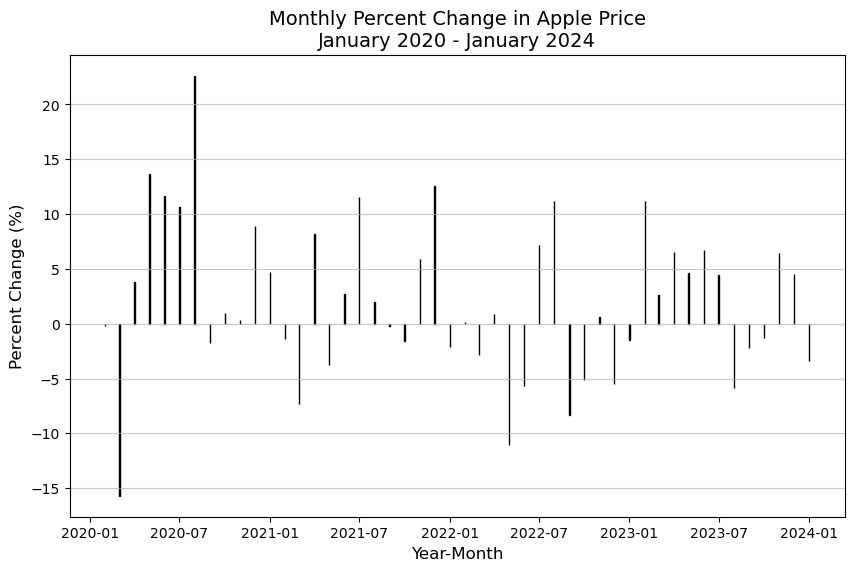

In [727]:
monthly_percent_change_viz(apple_monthly_avg, 'Apple')

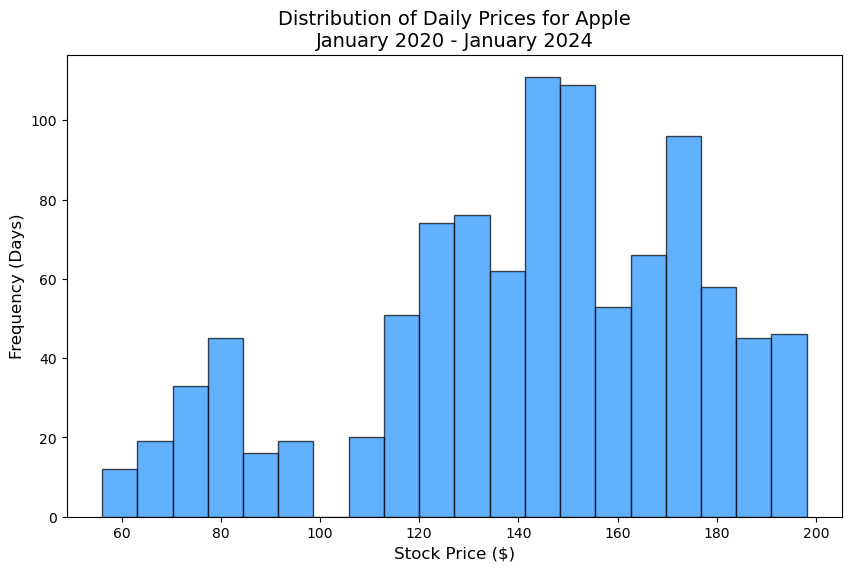

In [624]:
price_distribution_viz(assets, 'Apple_Price')

### Gold EDA

In [625]:
assets['Gold_Price'] = assets['Gold_Price'].str.replace(',', '') # need to remove commas to convert to float inside function

asset_summary_stats('Gold_Price')

Summary of Gold Prices
January 2, 2020 - January 31, 2024

    Statistic  Gold Price ($)       Date
Highest Price         2089.70 2023-12-01
 Lowest Price         1477.90 2020-03-18
Average Price         1838.73        NaT


In [626]:
avg_price_per_month('Gold_Price')

   Year  Month  Avg_Price  Percent_Change Month_Year  Positive_Month
0  2020      1    1562.27             NaN 2020-01-01               0
1  2020      2    1599.69            2.40 2020-02-01               1
2  2020      3    1598.59           -0.07 2020-03-01               0
3  2020      4    1707.73            6.83 2020-04-01               1
4  2020      5    1723.77            0.94 2020-05-01               1

Number of months where Gold_Price increased: 23

Number of months where Gold_Price decreased: 25

The average monthly percent return of the Gold_Price between January 2020 and January 2024' is 0.61%


/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/3603179910.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['Month_Year'] = pd.to_datetime(


,Year,Month,Avg_Price,Percent_Change,Month_Year,Positive_Month
0,2020,1,1562.27,NaN,2020-01-01,0
1,2020,2,1599.69,2.40,2020-02-01,1
2,2020,3,1598.59,-0.07,2020-03-01,0
3,2020,4,1707.73,6.83,2020-04-01,1
4,2020,5,1723.77,0.94,2020-05-01,1
5,2020,6,1743.81,1.16,2020-06-01,1
6,2020,7,1854.92,6.37,2020-07-01,1
7,2020,8,1980.27,6.76,2020-08-01,1
8,2020,9,1929.30,-2.57,2020-09-01,0
9,2020,10,1905.55,-1.23,2020-10-01,0


/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/3603179910.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['Month_Year'] = pd.to_datetime(


   Year  Month  Avg_Price  Percent_Change Month_Year  Positive_Month
0  2020      1    1562.27             NaN 2020-01-01               0
1  2020      2    1599.69            2.40 2020-02-01               1
2  2020      3    1598.59           -0.07 2020-03-01               0
3  2020      4    1707.73            6.83 2020-04-01               1
4  2020      5    1723.77            0.94 2020-05-01               1

Number of months where Gold_Price increased: 23

Number of months where Gold_Price decreased: 25

The average monthly percent return of the Gold_Price between January 2020 and January 2024' is 0.61%


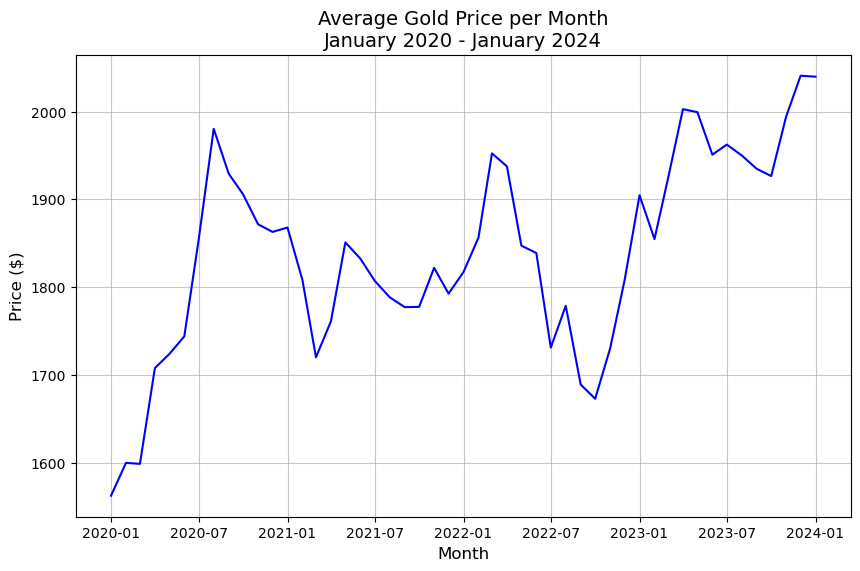

In [627]:
gold_monthly_avg = avg_price_per_month('Gold_Price')

avg_price_per_month_viz(gold_monthly_avg, 'Gold')

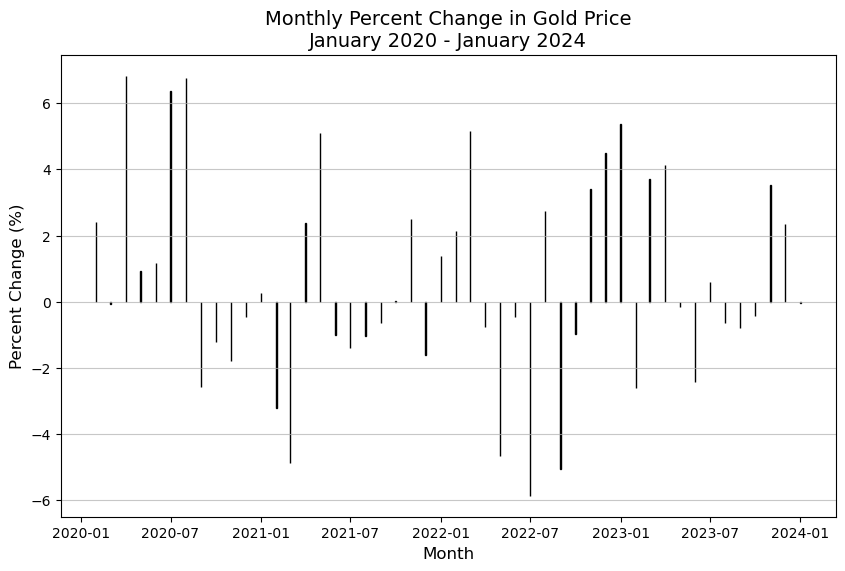

In [628]:
monthly_percent_change_viz(gold_monthly_avg, 'Gold')

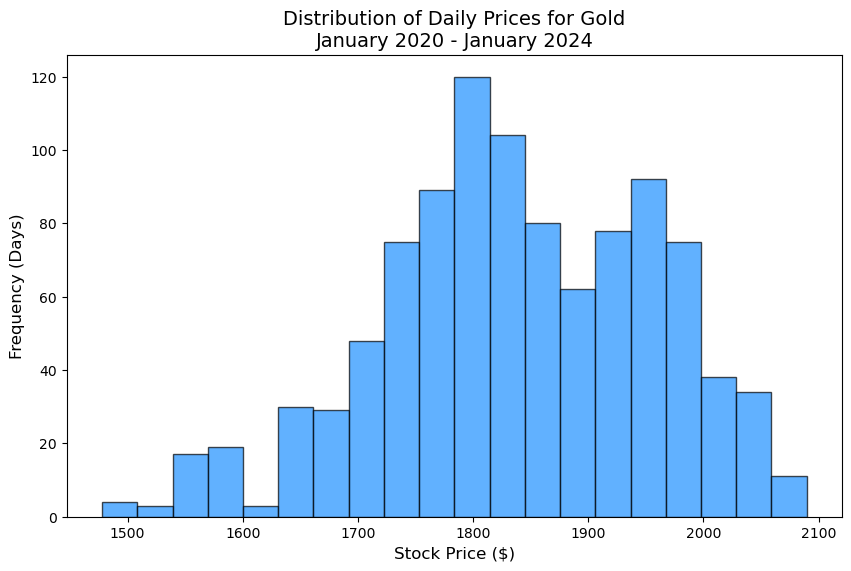

In [629]:
price_distribution_viz(assets, 'Gold_Price')

### Bitcoin EDA

In [630]:
assets['Bitcoin_Price'] = assets['Bitcoin_Price'].str.replace(',', '') # need to remove commas to convert to float inside function

asset_summary_stats('Bitcoin_Price')

Summary of Bitcoin Prices
January 2, 2020 - January 31, 2024

    Statistic  Bitcoin Price ($)       Date
Highest Price           67527.90 2021-11-08
 Lowest Price            4826.00 2020-03-12
Average Price           29188.05        NaT


In [631]:
avg_price_per_month('Bitcoin_Price')

   Year  Month  Avg_Price  Percent_Change Month_Year  Positive_Month
0  2020      1    8493.72             NaN 2020-01-01               0
1  2020      2    9632.28           13.40 2020-02-01               1
2  2020      3    6936.95          -27.98 2020-03-01               0
3  2020      4    7260.92            4.67 2020-04-01               1
4  2020      5    9308.66           28.20 2020-05-01               1

Number of months where Bitcoin_Price increased: 29

Number of months where Bitcoin_Price decreased: 19

The average monthly percent return of the Bitcoin_Price between January 2020 and January 2024' is 4.95%


/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/3603179910.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['Month_Year'] = pd.to_datetime(


,Year,Month,Avg_Price,Percent_Change,Month_Year,Positive_Month
0,2020,1,8493.72,NaN,2020-01-01,0
1,2020,2,9632.28,13.40,2020-02-01,1
2,2020,3,6936.95,-27.98,2020-03-01,0
3,2020,4,7260.92,4.67,2020-04-01,1
4,2020,5,9308.66,28.20,2020-05-01,1
5,2020,6,9519.96,2.27,2020-06-01,1
6,2020,7,9723.08,2.13,2020-07-01,1
7,2020,8,11631.33,19.63,2020-08-01,1
8,2020,9,10706.62,-7.95,2020-09-01,0
9,2020,10,11901.68,11.16,2020-10-01,1


   Year  Month  Avg_Price  Percent_Change Month_Year  Positive_Month
0  2020      1    8493.72             NaN 2020-01-01               0
1  2020      2    9632.28           13.40 2020-02-01               1
2  2020      3    6936.95          -27.98 2020-03-01               0
3  2020      4    7260.92            4.67 2020-04-01               1
4  2020      5    9308.66           28.20 2020-05-01               1

Number of months where Bitcoin_Price increased: 29

Number of months where Bitcoin_Price decreased: 19

The average monthly percent return of the Bitcoin_Price between January 2020 and January 2024' is 4.95%


/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/3603179910.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['Month_Year'] = pd.to_datetime(


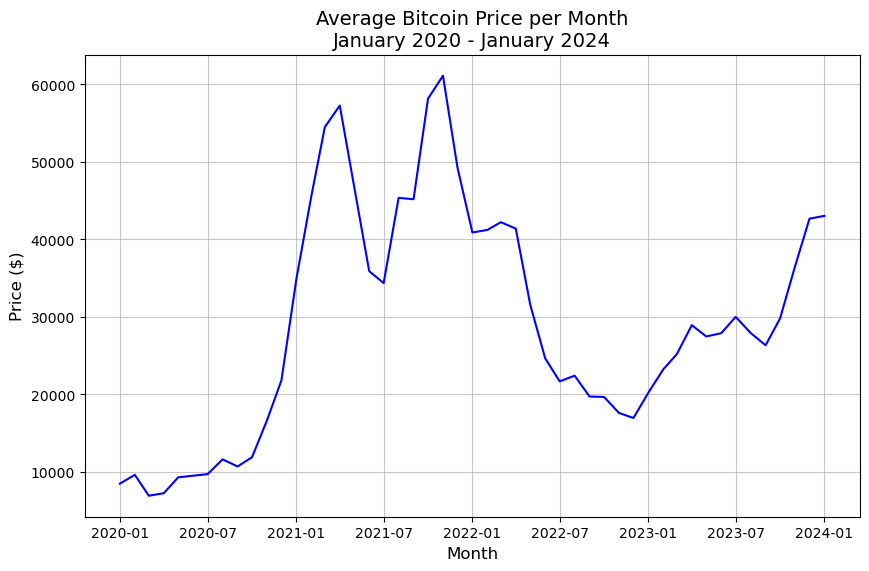

In [632]:
bitcoin_monthly_avg = avg_price_per_month('Bitcoin_Price')

avg_price_per_month_viz(bitcoin_monthly_avg, 'Bitcoin')

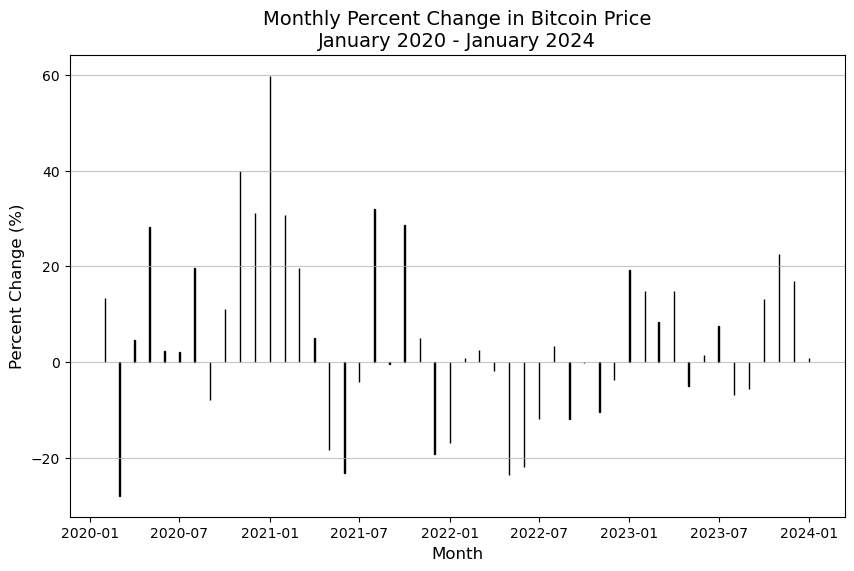

In [633]:
monthly_percent_change_viz(bitcoin_monthly_avg, 'Bitcoin')

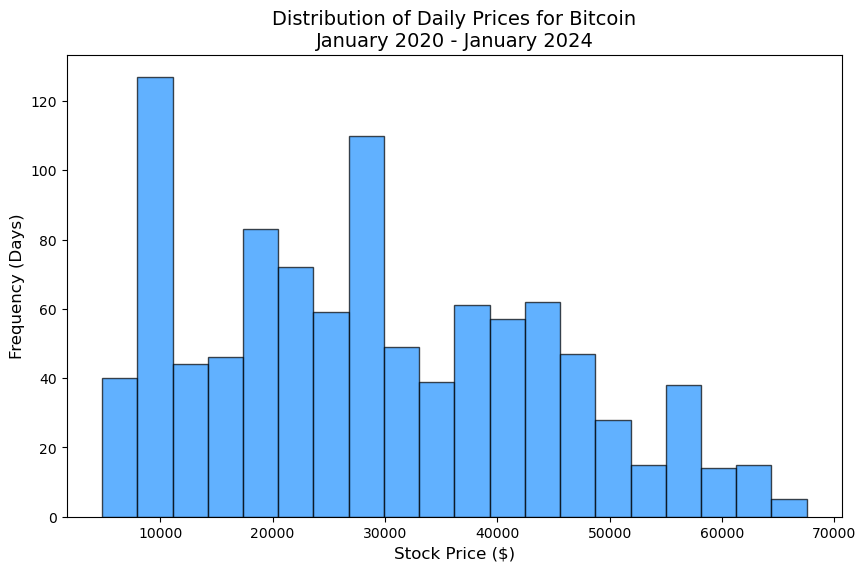

In [634]:
price_distribution_viz(assets, 'Bitcoin_Price')

# Regression

## Microsoft Regression

In [684]:
# lets look into the Microsoft stocks
m = assets[['Date','Date_Ordinal', 'Microsoft_Price','Microsoft_Vol.']].copy()

X = m[['Date_Ordinal']]  
y = m['Microsoft_Price']

# fit model
msft_model = LinearRegression()
msft_model.fit(X, y)

# predict and calculate metrics
y_pred = msft_model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1166.1879146116355
R-squared: 0.6432566909392003


In [685]:
X = sm.add_constant(X)

msft_model = sm.OLS(y, X).fit()

summary = msft_model.summary()
print(summary)

conf_int = msft_model.conf_int()

conf_int.columns = ['Lower CI', 'Upper CI']
print("\nConfidence Intervals for Coefficient:")
print(conf_int)

                            OLS Regression Results                            
Dep. Variable:        Microsoft_Price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1819.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):          4.56e-228
Time:                        17:59:49   Log-Likelihood:                -5004.1
No. Observations:                1011   AIC:                         1.001e+04
Df Residuals:                    1009   BIC:                         1.002e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          186.2631      2.148     86.734   

### **R-Squared:** 0.645
64.5% of the variance in the msft stock price can be explained using date.

### **const**: 186.0184
y-intercept of the regression line. Model predicts price of msft to be $186 on day 0, Jan 2nd 2020

### **Date_Ordinal:** 0.1067
coefficient represents the slope of the regression line. For each day, increase of 1 data ordinal, the msft stock price is expected to increase by about 10 cents ($0.10)

### P>|t|: 0.000
p-values, both are signifact (less than 0.05) meaning we have evidence date is a predictor of price

### Confidence Intervals:
[0.025      0.975]

181.799     190.238 

We can be 95% confident that the coefficient lies between 0.102 and 0.112, or 10 and 11 cents.

The model suggests that the Microsoft stock price has a positive trend over time, increasing by about $0.11 per day on average in the last 4 years.

In [686]:
coefficients = msft_model.params
intercept = coefficients['const']
slope = coefficients['Date_Ordinal']

print(coefficients)
print('\nIntercept:', intercept)
print('\nSlope:', slope)

const           186.263076
Date_Ordinal      0.106243
dtype: float64

Intercept: 186.26307602895352

Slope: 0.1062431535548475


In [689]:
# Ordinal Date spans from 0 - 1490
print("Day 400 Date:", m.loc[m['Date_Ordinal'] == 400, 'Date'].dt.strftime('%Y-%m-%d').values[0])

ordinal_day_to_predict = 400
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of MSFT Stock on Feb. 5, 2021 (day 400): " + "$" + str(predicted_price))

actual_day400_price = m.loc[m['Date_Ordinal'] == 400, 'Microsoft_Price'].values[0]
print("Actual Price of MSFT Stock on on Feb. 5, 2021 (day 400): " + "$" +  str(actual_day400_price))

Day 400 Date: 2021-02-05
Predicted Price of MSFT Stock on Feb. 5, 2021 (day 400): $228.76
Actual Price of MSFT Stock on on Feb. 5, 2021 (day 400): $242.2


In [690]:
# Predict into the future
ordinal_day_to_predict = 2000
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of MSFT Stock on day 2000 (June 24th, 2025): " + "$" + str(predicted_price))


Predicted Price of MSFT Stock on day 2000 (June 24th, 2025): $398.75


In [691]:
# PREDICT Jan 2026
from datetime import datetime, timedelta

# start date (date ordinal 0)
start_date = datetime(2020, 1, 2)

# calculate date 6 years later from start of data set, 2192 days later
jan_2026 = start_date + timedelta(days=2192)
print(jan_2026)

# predicting into the furture
ordinal_day_to_predict = 2192
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Microsoft Stock, January 2nd, 2026 (day 2192): " + '$' + str(predicted_price))


2026-01-02 00:00:00
Predicted Price of Microsoft Stock, January 2nd, 2026 (day 2192): $419.15


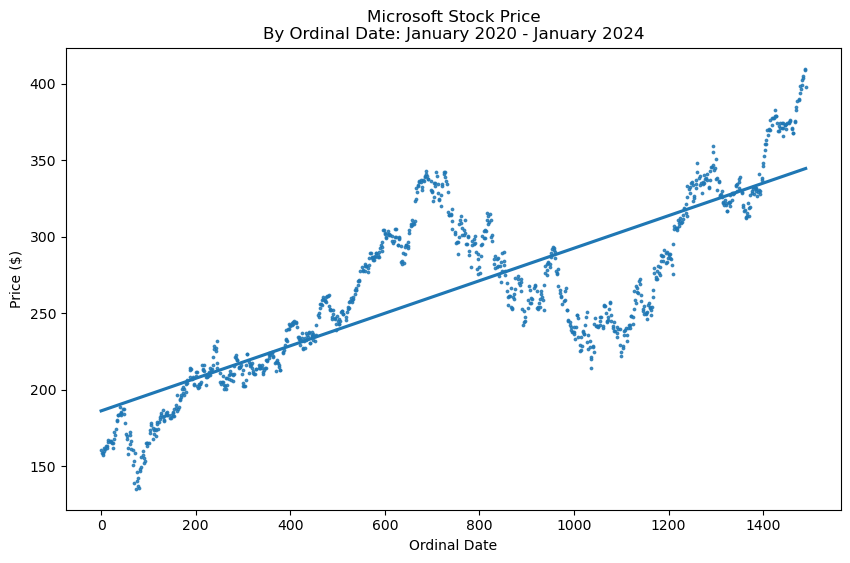

In [641]:
# graph with ordinal dates

plt.figure(figsize=(10,6))
sns.regplot(data = m , x='Date_Ordinal', y='Microsoft_Price', ci = None, scatter_kws={'s': 3})
plt.title("Microsoft Stock Price\nBy Ordinal Date: January 2020 - January 2024")
plt.ylabel("Price ($)")
plt.xlabel("Ordinal Date")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


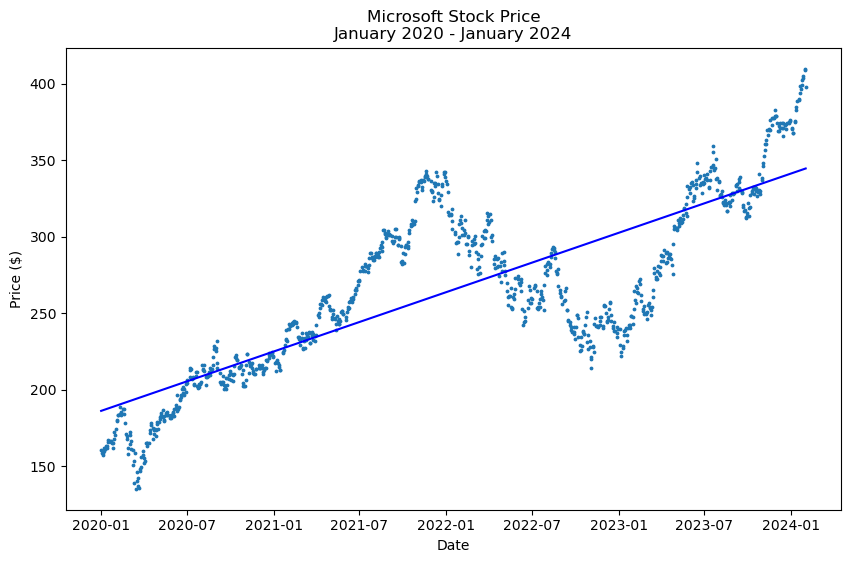

In [642]:
# graph with months and years
plt.figure(figsize=(10,6))
plt.scatter(data = m , x='Date', y='Microsoft_Price', s = 3, label = '')
sns.lineplot(x=m['Date'], y=msft_model.fittedvalues, color='blue')
plt.title("Microsoft Stock Price\nJanuary 2020 - January 2024")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

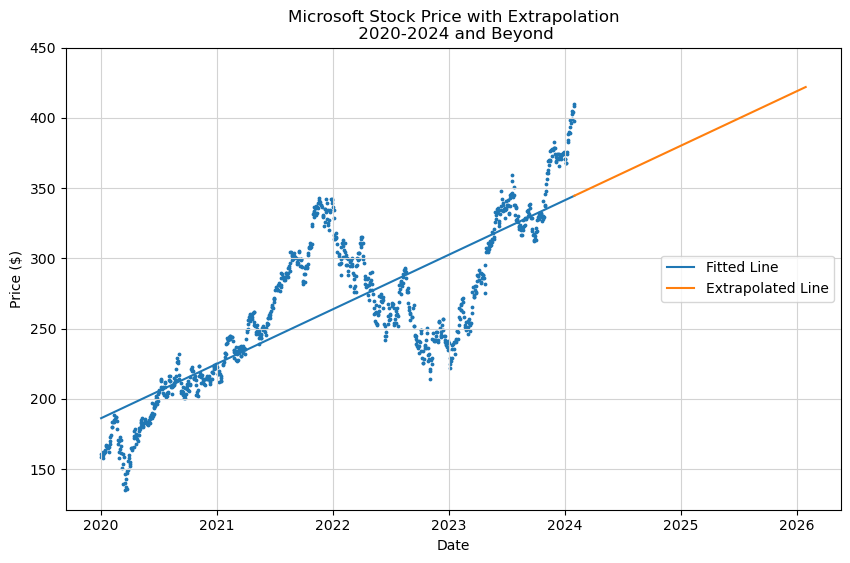

In [643]:
# extend date range for extrapolation
future_dates = pd.date_range(start=m['Date'].max(), periods=730, freq='D')  # extend by 365 days

# Create a df for future predictions
future_df = pd.DataFrame({'Date': future_dates})

# convert future dates to ordinal
future_df['Date_Ordinal'] = future_df['Date'].apply(lambda x: x.toordinal() - m['Date'].min().toordinal())

# constant column for intercept
future_df = sm.add_constant(future_df)

# predicitng future values
future_df['Predicted_Price'] = msft_model.predict(future_df[['const', 'Date_Ordinal']])

# plotting original data and extrapolated line
plt.figure(figsize=(10, 6))
plt.scatter(data=m, x='Date', y='Microsoft_Price', s=3, label='')
sns.lineplot(x=m['Date'], y=msft_model.fittedvalues, label='Fitted Line')
sns.lineplot(x=future_df['Date'], y=future_df['Predicted_Price'], label='Extrapolated Line')
plt.title("Microsoft Stock Price with Extrapolation\n 2020-2024 and Beyond")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend(loc = 'center right')
plt.yticks(np.arange(150, 500, 50))
plt.grid(color = 'lightgrey')
plt.show()

### Adding in Volume as feature

In [644]:
# regression with both Date_Ordinal and Microsoft_Vol.
X = m[['Date_Ordinal', 'Microsoft_Vol.']]
X = sm.add_constant(X) 

y = m['Microsoft_Price']

msft_model = sm.OLS(y, X).fit()

summary = msft_model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:        Microsoft_Price   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     983.2
Date:                Sun, 08 Dec 2024   Prob (F-statistic):          1.41e-237
Time:                        18:20:31   Log-Likelihood:                -4978.2
No. Observations:                1011   AIC:                             9962.
Df Residuals:                    1008   BIC:                             9977.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            209.1044      3.770     55.

Can see that volume has a very small negative relationship to price (-6.122e-07). The result is practiclaly zero, a fraction of a cent, so ther must not be a very stong relationship between price and volume.

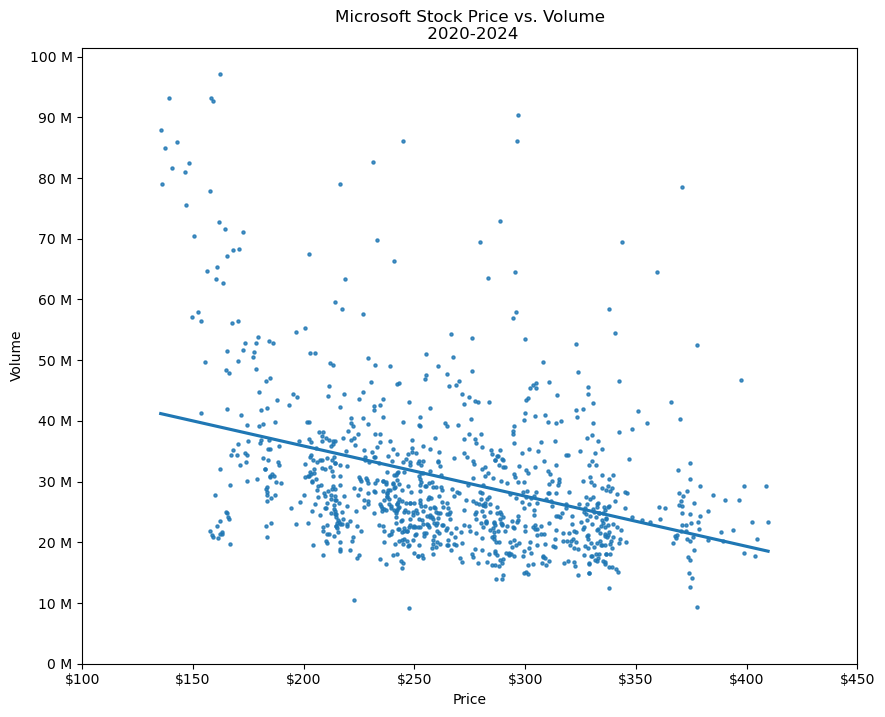

In [645]:
# graphing price vs. volume to see any trends

plt.figure(figsize=(10, 8))
sns.regplot(x = 'Microsoft_Price', y = 'Microsoft_Vol.', data = m, ci = None, scatter_kws={'s': 5})
plt.title("Microsoft Stock Price vs. Volume\n 2020-2024")
plt.xlabel('Price')
plt.ylabel('Volume')

y_ticks = np.arange(0, m['Microsoft_Vol.'].max() + 1e7, 1e7)  # step every 10 million
y_tick_labels = [f'{int(y_tick * 1e-6)} M' for y_tick in y_ticks]
plt.yticks(y_ticks, y_tick_labels)

x_ticks = plt.xticks()[0]  # Get current x-tick positions
x_tick_labels = [f'${int(x_tick)}' for x_tick in x_ticks]
plt.xticks(x_ticks, x_tick_labels)

plt.show()

## Apple Regression

In [728]:
apple = assets[['Date_Ordinal','Date', 'Apple_Price', 'Apple_Vol.']].copy()

print(apple)
print(apple.info())

      Date_Ordinal       Date  Apple_Price  Apple_Vol.
2             1490 2024-01-31       184.40    54830000
3             1489 2024-01-30       188.04    55270000
4             1488 2024-01-29       191.73    46890000
5             1485 2024-01-26       192.42    44590000
6             1484 2024-01-25       194.17    54530000
...            ...        ...          ...         ...
1008             6 2020-01-08        75.80   132360000
1009             5 2020-01-07        74.60   111510000
1010             4 2020-01-06        74.95   118580000
1011             1 2020-01-03        74.36   146540000
1012             0 2020-01-02        75.09   135650000

[1011 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 1011 entries, 2 to 1012
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date_Ordinal  1011 non-null   int64         
 1   Date          1011 non-null   datetime64[ns]
 2   Apple_Pri

In [ ]:
X = apple[['Date_Ordinal']]  
y = apple['Apple_Price']

apple_model = LinearRegression()
apple_model.fit(X, y)

y_pred = apple_model.predict(X)
mse = round(mean_squared_error(y, y_pred), 2)
r2 = round(r2_score(y, y_pred),4)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 266.98
R-squared: 0.7654


In [ ]:
X = sm.add_constant(X)

apple_model = sm.OLS(y, X).fit()

summary = apple_model.summary()
print(summary)

conf_int = apple_model.conf_int()

conf_int.columns = ['Lower CI', 'Upper CI']
print("\nConfidence Intervals for Coefficient:")
print(conf_int)

                            OLS Regression Results                            
Dep. Variable:            Apple_Price   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     3293.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):          5.65e-320
Time:                        20:47:44   Log-Likelihood:                -4258.9
No. Observations:                1011   AIC:                             8522.
Df Residuals:                    1009   BIC:                             8532.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           90.8355      1.028     88.402   

### **R-Squared:** 0.765
76.5% of the variance in the Apple stock price can be explained using date.

### **const**: 90.8355
y-intercept of the regression line. Model predicts price of Apple to be $90.86 on day 0 (Jan 2nd, 2020)

### **Date_Ordinal:** 0.0684
coefficient represents the slope of the regression line. For each day, increase of 1 data ordinal, the Apple stock price is expected to increase by about 7 cents ($0.0684)

### P>|t|: 0.000
p-values, both are signifact (less than 0.05) meaning we have evidence date is a predictor of price

### Confidence Intervals:
[0.025      0.975]

88.848      92.873

0.066       0.071 

We can be 95% confident that the coefficient lies between 0.066 and 0.071, or 6 and 7 cents. Additionally we are 95% confident that the y intercept or the first day in the table, Jan 2nd, 2020, will have a price between $88.85 and $92.87

The model suggests that the Apple stock price has a positive trend over time, increasing by about $0.06, 6 cents, per day on average in the last 4 years.

In [734]:
coefficients = apple_model.params
intercept = coefficients['const']
slope = coefficients['Date_Ordinal']

print(coefficients)
print('\nIntercept:', intercept)
print('\nSlope:', slope)

const           90.835512
Date_Ordinal     0.068387
dtype: float64

Intercept: 90.83551150243511

Slope: 0.06838683787836257


In [736]:
ordinal_day_to_predict = 502
print("Day 502 Date:", apple.loc[apple['Date_Ordinal'] == ordinal_day_to_predict, 'Date'].dt.strftime('%Y-%m-%d').values[0])

predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Apple Stock on May 18th, 2021 (Day 502): " + "$" +  str(predicted_price))

actual_day502_price = apple.loc[apple['Date_Ordinal'] == 502, 'Apple_Price'].values[0]
print("Actual Price of Apple Stock on May 18th, 2021 (Day 502): " + "$" + str(actual_day502_price))

Day 502 Date: 2021-05-18
Predicted Price of Apple Stock on May 18th, 2021 (Day 502): $125.17
Actual Price of Apple Stock on May 18th, 2021 (Day 502): $124.85


In [749]:
start_date = datetime(2020, 1, 2)

date_1600_days_later = start_date + timedelta(days=1600)
print(date_1600_days_later)

ordinal_day_to_predict = 1600
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted price of Apple stock on May 20th, 2024 (Day 1600): " + '$' + str(predicted_price))
print("Actual Apple stock price on May 20th, 2024 (Day 1600): $191.04")

2024-05-20 00:00:00
Predicted price of Apple stock on May 20th, 2024 (Day 1600): $200.25
Actual Apple stock price on May 20th, 2024 (Day 1600): $191.04


In [750]:
start_date = datetime(2020, 1, 2)

today = start_date + timedelta(days=1803)
print(today)

ordinal_day_to_predict = 1803
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted price of Apple stock on December 9th, 2024: " + '$' + str(predicted_price))
print("Actual Apple stock price on December 9th, 2024: $246.75")

2024-12-09 00:00:00
Predicted price of Apple stock on December 9th, 2024: $214.14
Actual Apple stock price on December 9th, 2024: $246.75


In [741]:
start_date = datetime(2020, 1, 2)

jan_2026 = start_date + timedelta(days=2192)
print(jan_2026)

ordinal_day_to_predict = 2192
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Apple Stock on January 2nd, 2026 (Day 2192): " + '$' + str(predicted_price))


2026-01-02 00:00:00
Predicted Price of Apple Stock on January 2nd, 2026 (Day 2192): $240.74


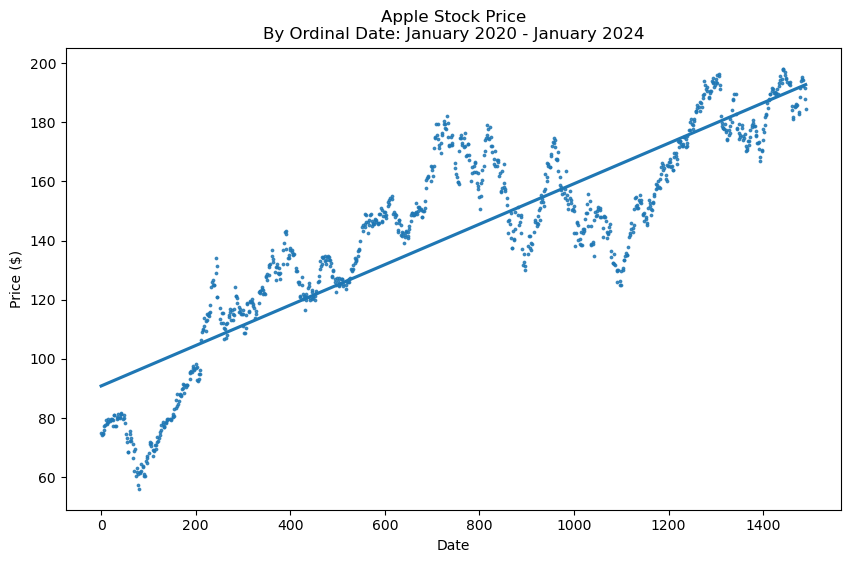

In [653]:
plt.figure(figsize=(10,6))
sns.regplot(data = apple , x='Date_Ordinal', y='Apple_Price', ci = None, scatter_kws={'s': 3})
plt.title("Apple Stock Price\nBy Ordinal Date: January 2020 - January 2024")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


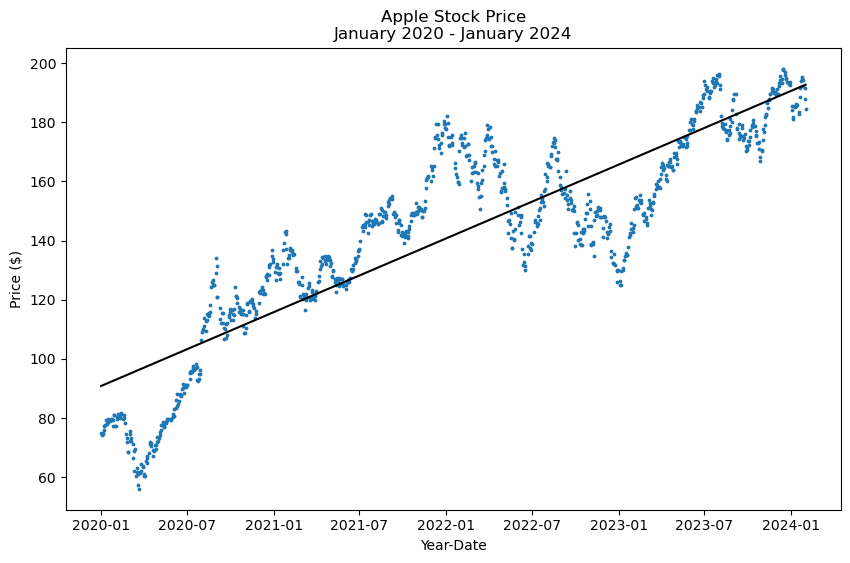

In [743]:
plt.figure(figsize=(10,6))
plt.scatter(data = apple , x='Date', y='Apple_Price', s = 3, label = '')
sns.lineplot(x=m['Date'], y=apple_model.fittedvalues, color='black')
plt.title("Apple Stock Price\nJanuary 2020 - January 2024")
plt.ylabel("Price ($)")
plt.xlabel("Year-Date")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

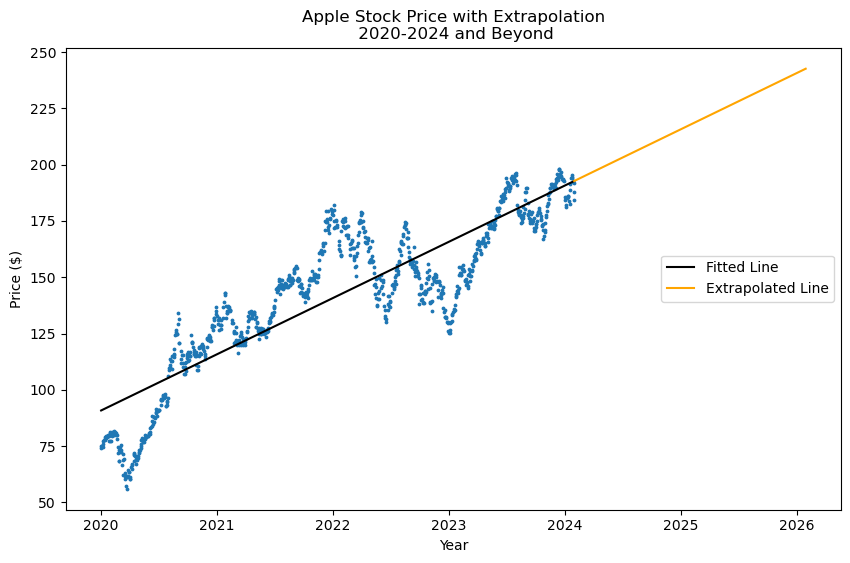

In [751]:
future_dates = pd.date_range(start=apple['Date'].max(), periods=730, freq='D')  # Extend by 2 years

future_df = pd.DataFrame({'Date': future_dates})

future_df['Date_Ordinal'] = future_df['Date'].apply(lambda x: x.toordinal() - apple['Date'].min().toordinal())

future_df = sm.add_constant(future_df)

future_df['Predicted_Price'] = apple_model.predict(future_df[['const', 'Date_Ordinal']])

plt.figure(figsize=(10, 6))
plt.scatter(data=apple, x='Date', y='Apple_Price', s=3, label='')
sns.lineplot(x=apple['Date'], y=apple_model.fittedvalues, label='Fitted Line', color='black')
sns.lineplot(x=future_df['Date'], y=future_df['Predicted_Price'], label='Extrapolated Line', color = "orange")
plt.title("Apple Stock Price with Extrapolation\n 2020-2024 and Beyond")
plt.ylabel("Price ($)")
plt.xlabel("Year")
plt.legend(loc = 'center right')
plt.show()

## Gold Regression

In [701]:
gold = assets[['Date_Ordinal', 'Date', 'Gold_Price', 'Gold_Vol.']]

gold['Gold_Price'] = gold['Gold_Price'].round(2)

print(gold)
print(gold.info())

      Date_Ordinal       Date  Gold_Price  Gold_Vol.
2             1490 2024-01-31      2067.4   238370.0
3             1489 2024-01-30      2050.9   214590.0
4             1488 2024-01-29      2034.9     1780.0
5             1485 2024-01-26      2026.6      410.0
6             1484 2024-01-25      2027.1      460.0
...            ...        ...         ...        ...
1008             6 2020-01-08      1560.2   813410.0
1009             5 2020-01-07      1574.3   435870.0
1010             4 2020-01-06      1568.8   558970.0
1011             1 2020-01-03      1552.4   436740.0
1012             0 2020-01-02      1528.1   270550.0

[1011 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 1011 entries, 2 to 1012
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date_Ordinal  1011 non-null   int64         
 1   Date          1011 non-null   datetime64[ns]
 2   Gold_Price    1011 non-null   flo

/var/folders/_6/bz7yx_zj1zqgplz2hx2bv_7h0000gn/T/ipykernel_30430/3693041718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold['Gold_Price'] = gold['Gold_Price'].round(2)


In [702]:
X = gold[['Date_Ordinal']]  
y = gold['Gold_Price']

gold_model = LinearRegression()
gold_model.fit(X, y)

y_pred = gold_model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 9496.263134109651
R-squared: 0.3261251168341148


In [703]:
X = sm.add_constant(X)

gold_model = sm.OLS(y, X).fit()

summary = gold_model.summary()
print(summary)

conf_int = gold_model.conf_int()

conf_int.columns = ['Lower CI', 'Upper CI']
print("\nConfidence Intervals for Coefficient:")
print(conf_int)

                            OLS Regression Results                            
Dep. Variable:             Gold_Price   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     488.3
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.45e-88
Time:                        18:06:58   Log-Likelihood:                -6064.2
No. Observations:                1011   AIC:                         1.213e+04
Df Residuals:                    1009   BIC:                         1.214e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1721.5027      6.128    280.918   

For Gold we have a very high MSE and low R-squared. This tell us that the relationship between time and the price of gold is not vert linear. So lets look at it on a plot to confirm our findings.

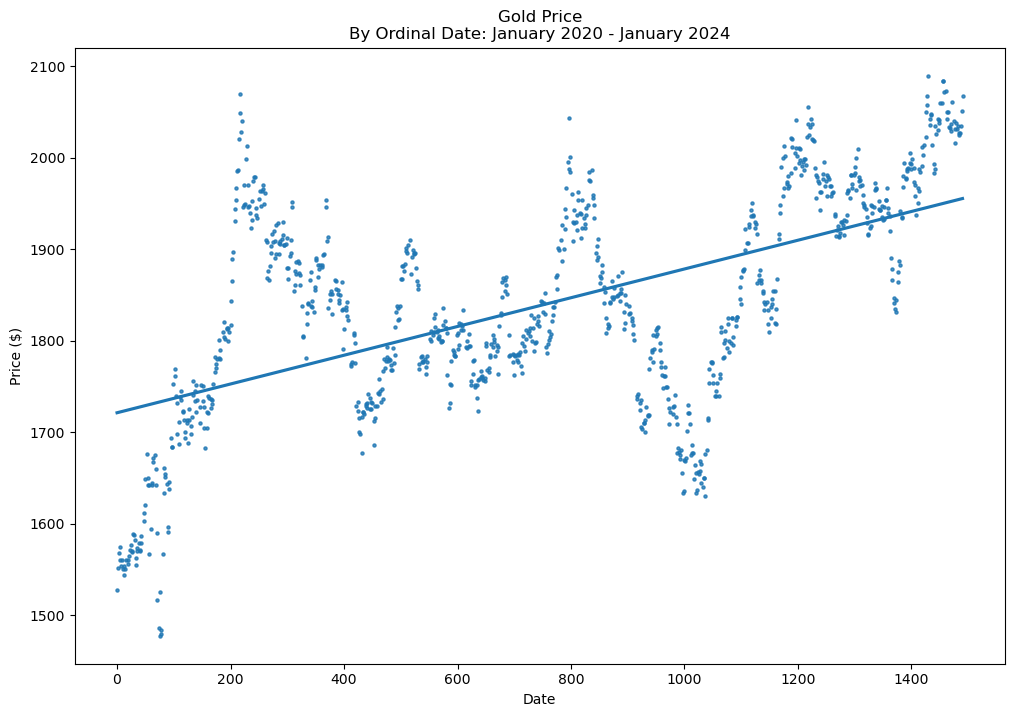

In [704]:
plt.figure(figsize=(12,8))
sns.regplot(data = gold , x='Date_Ordinal', y='Gold_Price', ci = None, scatter_kws={'s': 5})
plt.title("Gold Price\nBy Ordinal Date: January 2020 - January 2024")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


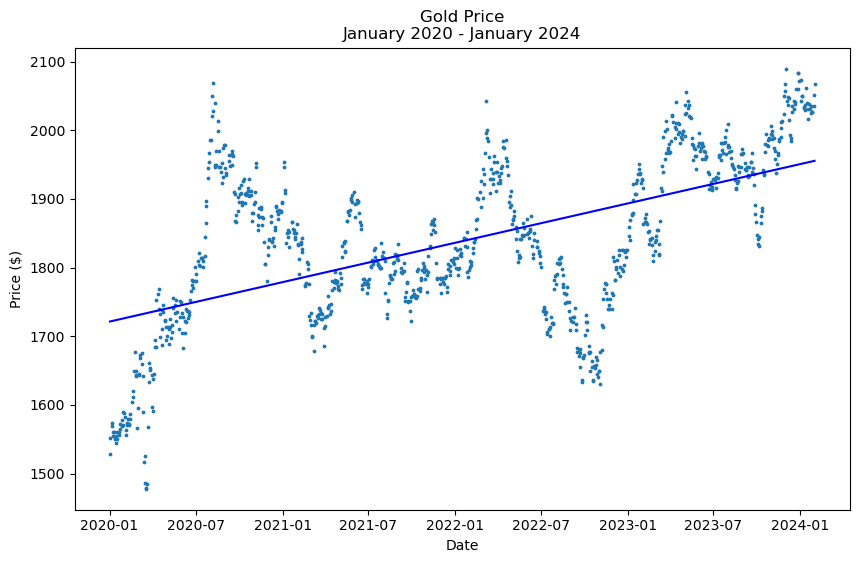

In [706]:
plt.figure(figsize=(10,6))
plt.scatter(data = gold , x='Date', y='Gold_Price', s = 3, label = '')
sns.lineplot(x=gold['Date'], y=gold_model.fittedvalues, color='blue')
plt.title("Gold Price\nJanuary 2020 - January 2024")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

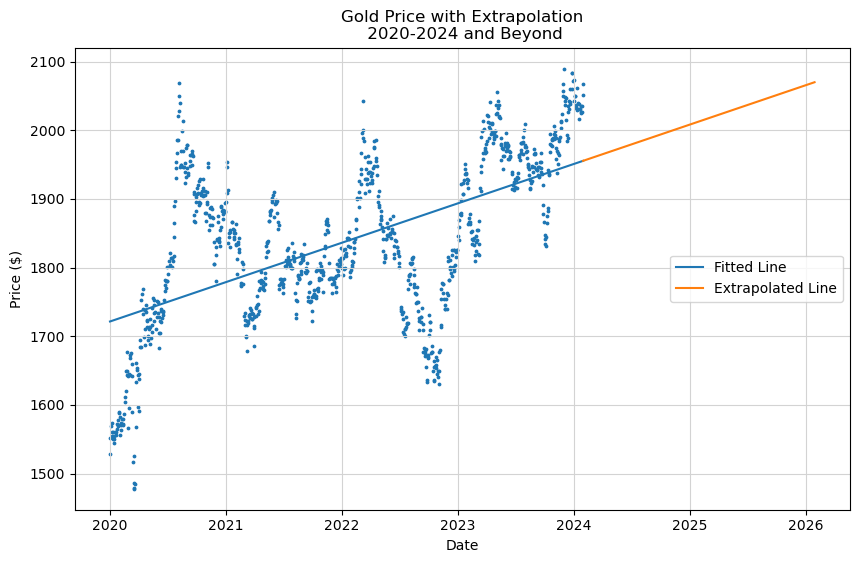

In [707]:
# extend date range for extrapolation
future_dates = pd.date_range(start=gold['Date'].max(), periods=730, freq='D')  # extend by 365 days

# Create a df for future predictions
future_df = pd.DataFrame({'Date': future_dates})

# convert future dates to ordinal
future_df['Date_Ordinal'] = future_df['Date'].apply(lambda x: x.toordinal() - gold['Date'].min().toordinal())

# constant column for intercept
future_df = sm.add_constant(future_df)

# predicitng future values
future_df['Predicted_Price'] = gold_model.predict(future_df[['const', 'Date_Ordinal']])

# plotting original data and extrapolated line
plt.figure(figsize=(10, 6))
plt.scatter(data=gold, x='Date', y='Gold_Price', s=3, label='')
sns.lineplot(x=gold['Date'], y=gold_model.fittedvalues, label='Fitted Line')
sns.lineplot(x=future_df['Date'], y=future_df['Predicted_Price'], label='Extrapolated Line')
plt.title("Gold Price with Extrapolation\n 2020-2024 and Beyond")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend(loc = 'center right')
plt.grid(color = 'lightgrey')
plt.show()

In [708]:
coefficients = gold_model.params
intercept = coefficients['const']
slope = coefficients['Date_Ordinal']

print(coefficients)
print('\nIntercept:', intercept)
print('\nSlope:', slope)

const           1721.502676
Date_Ordinal       0.157066
dtype: float64

Intercept: 1721.5026755141057

Slope: 0.15706568260190604


In [709]:
# Ordinal Date spans from 0 - 1490
print("Day 400 Date:", gold.loc[gold['Date_Ordinal'] == 400, 'Date'].dt.strftime('%Y-%m-%d').values[0])

ordinal_day_to_predict = 400
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Gold on Feb. 5, 2021 (day 400): " + "$" + str(predicted_price))

actual_day400_price = gold.loc[gold['Date_Ordinal'] == ordinal_day_to_predict, 'Gold_Price'].values[0]
print("Actual Price of Gold on Feb. 5, 2021 (day 400) " + "$" +  str(actual_day400_price))

Day 400 Date: 2021-02-05
Predicted Price of Gold on Feb. 5, 2021 (day 400): $1784.33
Actual Price of Gold on Feb. 5, 2021 (day 400) $1813.0


In [711]:
# Predict into the future
start_date = datetime(2020, 1, 2)

# calculate date 1600 days later
date_2000_days_later = start_date + timedelta(days=2000)
print(date_2000_days_later)

ordinal_day_to_predict = 2000
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Gold on June 24th, 2025 (day 2000): " + "$" + str(predicted_price))

2025-06-24 00:00:00
Predicted Price of Gold on June 24th, 2025 (day 2000): $2035.63


In [665]:
# PREDICT Jan 2026
from datetime import datetime, timedelta

# start date (date ordinal 0)
start_date = datetime(2020, 1, 2)

# calculate date 6 years later from start of data set, 2192 days later
jan_2026 = start_date + timedelta(days=2192)
print(jan_2026)

# predicting into the furture
ordinal_day_to_predict = 2192
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Gold, January 2nd, 2026 (day 2192): " + '$' + str(predicted_price))


2026-01-02 00:00:00
Predicted Price of Gold, January 2nd, 2026 (day 2192): $2065.79


## Bitcoin Regression

In [712]:
# Bitcoin
btc = assets[['Date', 'Date_Ordinal', 'Bitcoin_Price', 'Bitcoin_Vol.']]
print(btc)

# can see Bitcoin_Price column is an object, need price to be float
print(btc.info())

           Date  Date_Ordinal  Bitcoin_Price  Bitcoin_Vol.
2    2024-01-31          1490        42580.5         56480
3    2024-01-30          1489        42946.2         55130
4    2024-01-29          1488        43299.8         45230
5    2024-01-26          1485        41811.3         69470
6    2024-01-25          1484        39935.7         46300
...         ...           ...            ...           ...
1008 2020-01-08             6         8059.6       1190000
1009 2020-01-07             5         8155.7       1010000
1010 2020-01-06             4         7759.1        786750
1011 2020-01-03             1         7343.1        936290
1012 2020-01-02             0         6967.0        632780

[1011 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 1011 entries, 2 to 1012
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1011 non-null   datetime64[ns]
 1   Date_Ord

In [713]:
X = btc[['Date_Ordinal']]  
y = btc['Bitcoin_Price']

# Fit model
btc_model = LinearRegression()
btc_model.fit(X, y)

# Predict and calculate metrics
y_pred = btc_model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 211155539.69147703
R-squared: 0.07519363240328625


In [714]:
X = sm.add_constant(X)

btc_model = sm.OLS(y, X).fit()

summary = btc_model.summary()
print(summary)

conf_int = btc_model.conf_int()

conf_int.columns = ['Lower CI', 'Upper CI']
print("\nConfidence Intervals for Coefficient:")
print(conf_int)

                            OLS Regression Results                            
Dep. Variable:          Bitcoin_Price   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     82.04
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           6.75e-19
Time:                        18:11:28   Log-Likelihood:                -11124.
No. Observations:                1011   AIC:                         2.225e+04
Df Residuals:                    1009   BIC:                         2.226e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.202e+04    913.804     24.100   

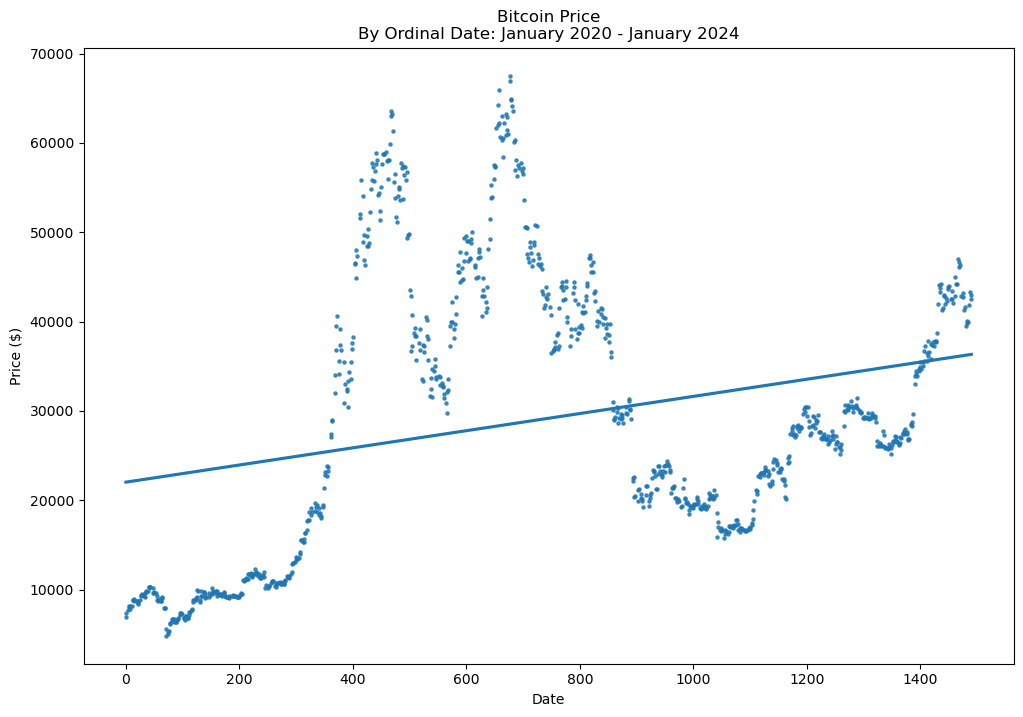

In [715]:
plt.figure(figsize=(12,8))
sns.regplot(data = btc , x='Date_Ordinal', y='Bitcoin_Price', ci = None, scatter_kws={'s': 5})
plt.title("Bitcoin Price\nBy Ordinal Date: January 2020 - January 2024")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


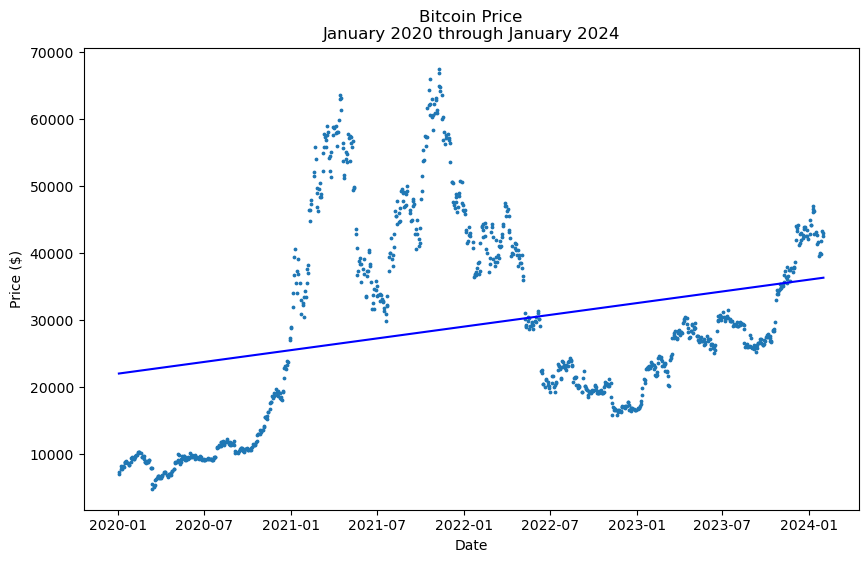

In [716]:
# graph with months and years
plt.figure(figsize=(10,6))
plt.scatter(data = btc , x='Date', y='Bitcoin_Price', s = 3, label = '')
sns.lineplot(x=btc['Date'], y=btc_model.fittedvalues, color='blue')
plt.title("Bitcoin Price\nJanuary 2020 through January 2024")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

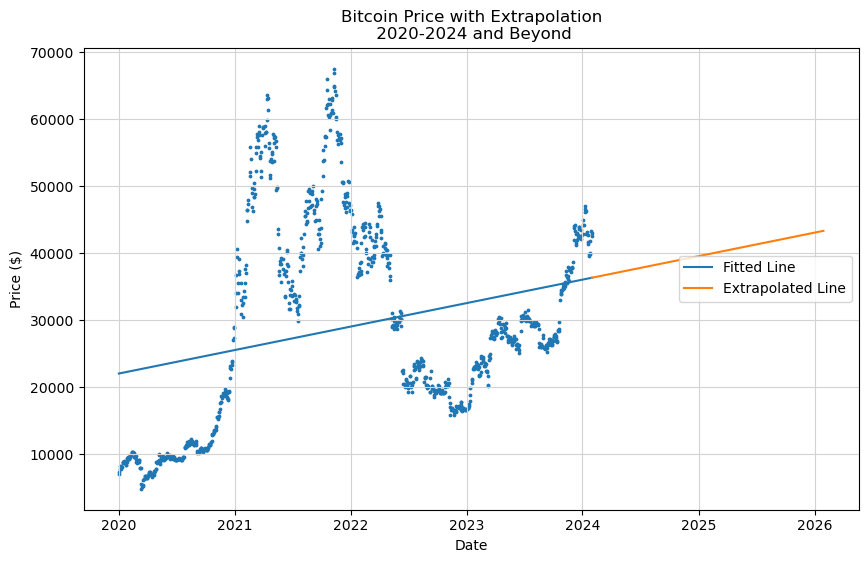

In [717]:
# extend date range for extrapolation
future_dates = pd.date_range(start=m['Date'].max(), periods=730, freq='D')  # extend by 365 days

# Create a df for future predictions
future_df = pd.DataFrame({'Date': future_dates})

# convert future dates to ordinal
future_df['Date_Ordinal'] = future_df['Date'].apply(lambda x: x.toordinal() - btc['Date'].min().toordinal())

# constant column for intercept
future_df = sm.add_constant(future_df)

# predicitng future values
future_df['Predicted_Price'] = btc_model.predict(future_df[['const', 'Date_Ordinal']])

# plotting original data and extrapolated line
plt.figure(figsize=(10, 6))
plt.scatter(data=btc, x='Date', y='Bitcoin_Price', s=3, label='')
sns.lineplot(x=btc['Date'], y=btc_model.fittedvalues, label='Fitted Line')
sns.lineplot(x=future_df['Date'], y=future_df['Predicted_Price'], label='Extrapolated Line')
plt.title("Bitcoin Price with Extrapolation\n 2020-2024 and Beyond")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend(loc = 'center right')
plt.grid(color = 'lightgrey')
plt.show()

In [718]:
coefficients = btc_model.params
intercept = coefficients['const']
slope = coefficients['Date_Ordinal']

print(coefficients)
print('\nIntercept:', intercept)
print('\nSlope:', slope)

const           22023.046049
Date_Ordinal        9.599947
dtype: float64

Intercept: 22023.046048684788

Slope: 9.599946518846773


In [719]:
# Ordinal Date spans from 0 - 1490
print("Day 400 Date:", btc.loc[btc['Date_Ordinal'] == 400, 'Date'].dt.strftime('%Y-%m-%d').values[0])

ordinal_day_to_predict = 400
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Bitcoin on Feb. 5, 2021 (day 400): " + "$" + str(predicted_price))

actual_day400_price = btc.loc[btc['Date_Ordinal'] == 400, 'Bitcoin_Price'].values[0]
print("Actual Price of Bitcoin on Feb. 5, 2021 (day 400): " + "$" + str(actual_day400_price))

Day 400 Date: 2021-02-05
Predicted Price of Bitcoin on Feb. 5, 2021 (day 400): $25863.02
Actual Price of Bitcoin on Feb. 5, 2021 (day 400): $38297.6


In [720]:
# Predict into the future
start_date = datetime(2020, 1, 2) # start date (date ordinal 0)
ordinal_day_to_predict = 2000

# calculate date 6 years later from start of data set, 2192 days later
date_2000_days_later = start_date + timedelta(days=ordinal_day_to_predict)
print(date_2000_days_later)

predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Bitcoin on day 2000 (June 24th, 2025): " + "$" + str(predicted_price))

2025-06-24 00:00:00
Predicted Price of Bitcoin on day 2000 (June 24th, 2025): $41222.94


In [721]:
# PREDICT Jan 2026
from datetime import datetime, timedelta

# start date (date ordinal 0)
start_date = datetime(2020, 1, 2)

# calculate date 6 years later from start of data set, 2192 days later
jan_2026 = start_date + timedelta(days=2192)
print(jan_2026)

# predicting into the furture
ordinal_day_to_predict = 2192
predicted_price = round(intercept + (slope * ordinal_day_to_predict),2)
print("Predicted Price of Bitcoin, January 2nd, 2026 (day 2192): " + '$' + str(predicted_price))

2026-01-02 00:00:00
Predicted Price of Bitcoin, January 2nd, 2026 (day 2192): $43066.13


Based on this models extrapolated line, and predicted prices, we can conclude that time and the price of Bitcoin do not have a linear relationship. Even though the price of crypto has increased since the start of the dataset, we still see a large amount of flunctuation in the cyrptos price leading to a less accurate linear model.  